# Задачи к Лекции 2

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r"C:\Users\Роксана\Downloads\mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
df.shape

(70000, 12)

## Задачи

**1. Построить наивный байесовский классификатор для количественных полей age, height, weight, ap_hi, ap_lo. Исправить данные, если это необходимо. Привести матрицу неточностей и сравнить со значением полученным в ходе лекции. Попытаться объяснить разницу.**

In [178]:
#проверю, сколько строк убралось
print(len(df) - len(clean_df))

1274


In [179]:
#ТЕПЕРЬ СТРОЮ КЛАССИФИКАТОР
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
#выбираю нужные признаки
train_quant = clean_df[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]
target = clean_df['cardio']

quant_model = gnb.fit(train_quant, target)
predict = quant_model.predict(train_quant)
print(clean_df.shape[0],
     (target == predict).sum() / clean_df.shape[0])

predict

68726 0.7085237028198935


array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [180]:
quant_model.predict(train_quant[1:2]), quant_model.predict_proba(train_quant[1:2])

(array([1], dtype=int64), array([[0.11064067, 0.88935933]]))

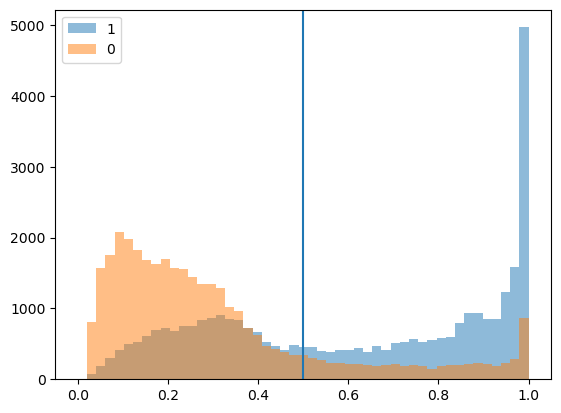

In [181]:
prob = quant_model.predict_proba(train_quant)[:,1]
plt.hist(prob[target == 1], bins=np.linspace(0, 1, 50), alpha=0.5, label="1");
plt.hist(prob[target == 0], bins=np.linspace(0, 1, 50), alpha=0.5, label="0");
plt.axvline(0.5)
plt.legend()
plt.show()

In [182]:
#ДЕЛАЮ МАТРИЦУ НЕТОЧНОСТЕЙ
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(target, predict)
import itertools
class_names = ["Здоров", "Болен"]
def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица неточностей', cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.4f' if normalize else 'd'
    thresh = cm.min() + (cm.max() - cm.min()) * 2 / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Истина')
    plt.xlabel('Предсказание')
    plt.tight_layout()

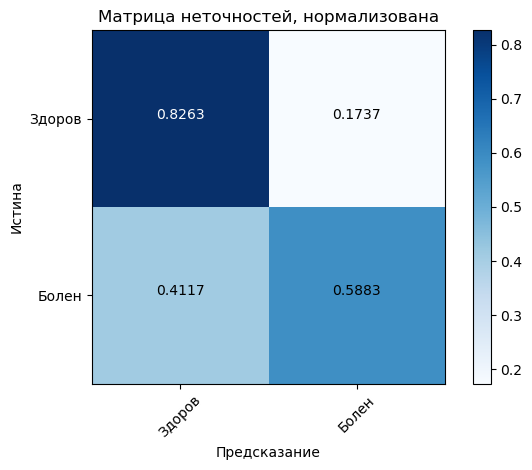

In [183]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,                      
                      title='Матрица неточностей, нормализована')
plt.show()

**Комментарии:** По сравнению с значением полученным в ходе лекции, видно, что в целом точность для здоровых улучшилась. В лекции модель правильно определяла 62.31% реально здоровых, но 38.18% ошибочно классифицировала как больных. Моя модель правильно определяет 82.63% здоровых, ошибаясь всего в 17.37%. Однако точность по больным снизилась до 58.83% (в лекции было 62.31%), количество ошибок возросло до 41.17% (в лекции было 37.69%).

**2. Написать свой наивный байесовский классификатор для категориальных полей cholesterol, gluc. Привести матрицу неточностей и сравнить со значениями из задачи 1 (нельзя использовать готовое решение из sklearn) (не обязательно)**

In [184]:
#выбираю нужные признаки
train_cat = clean_df[['cholesterol', 'gluc']]
target = clean_df['cardio']

In [185]:
#делаю свой классификатор
class myclassificator:
    def __init__(self):
        self.prior = None      
        self.likelihood = None   
    def fit(self, train_cat, target):
        self.classes = np.unique(target)
        #рассчитываю априорные вероятности
        self.prior = {c: np.mean(target == c) for c in self.classes}
        #рассчитываю условные вероятности
        self.likelihood = {}
        for feature in train_cat.columns:
            for c in self.classes:
                subset = train_cat[target == c][feature]
                #считаю условные вероятности для каждого значения признака
                counts = subset.value_counts(normalize=True)
                self.likelihood[(feature, c)] = counts.to_dict()
    def predict(self, train_cat):
        predictions = []
        for _, sample in train_cat.iterrows():
            posteriors = []
            for c in self.classes:
                posterior = np.log(self.prior[c])  #использую логарифм для численной стабильности
                #добавляю вклад каждого признака
                for feature in train_cat.columns:
                    val = sample[feature]
                    prob = self.likelihood.get((feature, c), {}).get(val, 0)
                    posterior += np.log(prob) if prob > 0 else -np.inf
                posteriors.append((posterior, c))
            #выбираю класс с максимальной апостериорной вероятностью
            predictions.append(max(posteriors)[1])
        return np.array(predictions)

In [186]:
#теперь обучаю модель
cat_model = myclassificator()
cat_model.fit(train_cat, target)

In [187]:
predict = cat_model.predict(train_cat)
print(clean_df.shape[0],
     (target == predict).sum() / clean_df.shape[0])

predict

68726 0.5920321275790822


array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [188]:
#добавляю метод predict_proba
def predict_proba(self, train_cat):
    probas = []
    for _, sample in train_cat.iterrows():
        class_probs = {}
        for c in self.classes:
            posterior = np.log(self.prior[c])
            for feature in train_cat.columns:
                val = sample[feature]
                prob = self.likelihood.get((feature, c), {}).get(val, 1e-5)  #небольшое сглаживание
                posterior += np.log(prob)
            class_probs[c] = np.exp(posterior)
        #нормализую
        total = sum(class_probs.values())
        probas.append([class_probs[0]/total, class_probs[1]/total])
    return np.array(probas)

In [189]:
myclassificator.predict_proba = predict_proba
cat_proba = cat_model.predict_proba(train_cat)

In [190]:
cat_model.predict(train_quant[1:2]), cat_model.predict_proba(train_cat[1:2])

(array([1], dtype=int64), array([[0.25133904, 0.74866096]]))

In [191]:
#СТРОЮ МАТРИЦУ НЕТОЧНОСТЕЙ
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(target, predict)
import itertools
class_names = ["Здоров", "Болен"]
def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица неточностей', cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.4f' if normalize else 'd'
    thresh = cm.min() + (cm.max() - cm.min()) * 2 / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Истина')
    plt.xlabel('Предсказание')
    plt.tight_layout()

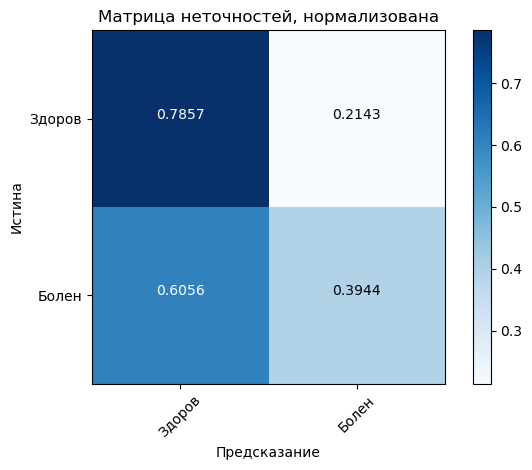

In [192]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,                      
                      title='Матрица неточностей, нормализована')
plt.show()

**Комментарии:** Модель правильно определяет 78.57% здоровых, однако точность по больным очень низкая - 39.44%. По сравнению с результатами из задачи 1 модель больше ошибается (ошибочно определяет больных как здоровых аж в 60.56% случаев).

**3. Построить наивный байесовский классификатор для бинарных полей gender, smoke, alco, active. Привести матрицу неточностей и сравнить с предыдущими значениями.**

In [193]:
#Использую модель BernoulliNB, так как у нас бинарные признаки
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
#выбираю нужные признаки
train_bin = clean_df[['gender', 'smoke', 'alco', 'active']]
target = clean_df['cardio']

bin_model = bnb.fit(train_bin, target)
predict = bin_model.predict(train_bin)
print(clean_df.shape[0],
     (target == predict).sum() / clean_df.shape[0])

predict

68726 0.5175770450775543


array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [194]:
bin_model.predict(train_bin[1:2]), bin_model.predict_proba(train_bin[1:2])

(array([0], dtype=int64), array([[0.51085961, 0.48914039]]))

In [195]:
#СТРОЮ МАТРИЦУ НЕТОЧНОСТЕЙ
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(target, predict)
import itertools
class_names = ["Здоров", "Болен"]
def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица неточностей', cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.4f' if normalize else 'd'
    thresh = cm.min() + (cm.max() - cm.min()) * 2 / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Истина')
    plt.xlabel('Предсказание')
    plt.tight_layout()

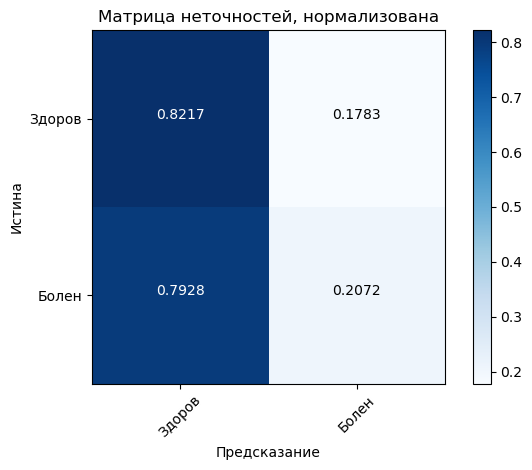

In [196]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,                      
                      title='Матрица неточностей, нормализована')
plt.show()

**Комментарии:** Эта модель на бинарных признаках в целом предсказывает намного хуже, чем на количественных признаках. Больных ошибочно определяет как здоровых аж в 79.28%.

**4. К этому моменту у вас есть три независимых классификатора: по количественным полям, категориальным и бинарным. Придумать, как их объединить в один единый классификатор, который учитывает все эти поля. Привести матрицу неточностей для него и сравнить с предыдущими значениями. Попытаться объяснить разницу.**

In [197]:
#ОБЪЕДИНЕНИЕ ЧЕРЕЗ УСРЕДНЕНИЕ ВЕРОЯТНОСТЕЙ

#для начала оцениваю чувствительность (recall) каждой модели для класса "болен"
from sklearn.metrics import recall_score
quant_recall = recall_score(target, quant_model.predict(train_quant), pos_label=1)
cat_recall = recall_score(target, cat_model.predict(train_cat), pos_label=1)
bin_recall = recall_score(target, bin_model.predict(train_bin), pos_label=1)

In [170]:
print("Точность определения больных\nс количественными признаками:",quant_recall,"\nс категориальными признаками:",cat_recall,"\nс бинарными признаками",bin_recall)

Точность определения больных
с количественными признаками: 0.5882750712962691 
с категориальными признаками: 0.3943786199394349 
с бинарными признаками 0.20721488842501395


In [198]:
#задаю веса пропорционально recall
weights = [quant_recall, cat_recall, bin_recall]
weights = np.array(weights) / sum(weights)  #нормализация

In [199]:
#взвешенное усреднение вероятностей с акцентом на класс болен
weighted_proba = (
    weights[0] * quant_model.predict_proba(train_quant)[:, 1] +
    weights[1] * cat_model.predict_proba(train_cat)[:, 1] +
    weights[2] * bin_model.predict_proba(train_bin)[:, 1]
)

In [200]:
final_predict = (weighted_proba > 0.4).astype(int)

In [201]:
#СТРОЮ МАТРИЦУ НЕТОЧНОСТЕЙ
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(target, final_predict)
import itertools
class_names = ["Здоров", "Болен"]
def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица неточностей', cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.4f' if normalize else 'd'
    thresh = cm.min() + (cm.max() - cm.min()) * 2 / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Истина')
    plt.xlabel('Предсказание')
    plt.tight_layout()

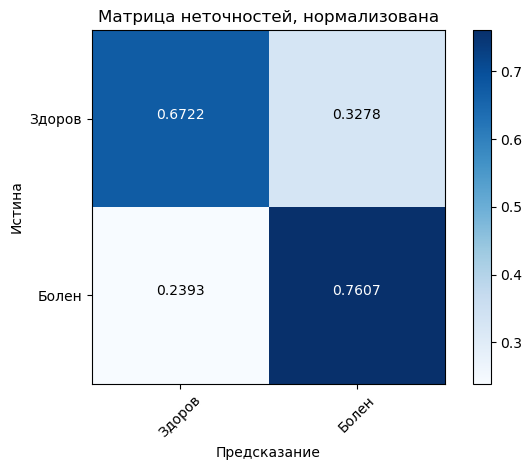

In [202]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,                      
                      title='Матрица неточностей, нормализована')
plt.show()

**Комментарии:** Комплексный учет признаков дает лучший результат, вероятность успешного обнаружения больных возросла аж до 76.07%.

**5. (Не обязательно) Теперь мы умеем делать классификацию в рамках наивного предположения об независимости всех признаков. Сейчас же нужно попробовать учесть взаимосвязь между признаками через условные вероятности. Построить классификатор с учетом такой связи. Сравнить результат с ранее полученными значениями.**

**Комментарии:** Ваши комментарии здесь.